# Random Forests

- use scikit-learn for **random forests**
- do **ordinal encoding** with high-cardinality categoricals
- understand how categorical encodings affect trees differently compared to linear models
- understand how tree ensembles reduce overfitting compared to a single decision tree with unlimited depth

In [ ]:
# %%capture
# ### PLEASE DO NOT USE THIS CELL TO GET YOUR DATA FROM GITHUB. IT'S AN OUTDATED LINK.
# ### DOWNLOAD YOUR FILES FROM KAGGLE.

# import sys

# # If you're on Colab:
# if 'google.colab' in sys.modules:
#     DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    # !pip install category_encoders==2.*

# # If you're working locally:
# else:
#     DATA_PATH = '../data/'

In [ ]:
!pip install category_encoders==2.*
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')
  else:
    df = pd.read_csv(fm_path, 
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Explore why they didn't drop construction_year

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns
  dupe_cols = [col for col in df.head().T.duplicated().index
               if df.head().T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)             

  return df

df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

# II. Split Data

In [ ]:
# Extraction type, Extraction type group look similar
# Drop all duplicated columns
# .T.duplicated() You transpose the columns before checking for duplicating, then transpose it back
dupe_cols = [col for col in df.head(15).T.duplicated().index
             if df.head(15).T.duplicated()[col]]
df.drop(columns=dupe_cols, inplace=True)

In [ ]:
df.info()

In [ ]:
X_test.info()

## Split TV from FM

In [ ]:
target = 'status_group'

In [ ]:
y=df[target]
X=df.drop(columns=target)

# Training-Validation Split

- Randomized split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

# III. Establish Baseline

This is a **classification** problem, our baseline will be **accuracy**. 

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:',baseline_acc)

Baseline Accuracy: 0.5425489938182296


# IV. Build Model(s)

- Missing values
- Categorical values

In [ ]:
model_dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'), #Try using KNN Imputer
    DecisionTreeClassifier(random_state=42),
)

model_dt.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                drop_invariant=False,...
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                             

In [ ]:
model_dt.named_steps['decisiontreeclassifier'].get_depth()

38

In [ ]:
print('Model_dt accuracy score for training:',accuracy_score(y_train,model_dt.predict(X_train)))
print('Model_dt accuracy score for training:',accuracy_score(y_val,model_dt.predict(X_val)))

Model_dt accuracy score for training: 0.995475470209128
Model_dt accuracy score for training: 0.741266835016835


In [ ]:
# Important parameters to tune for RF: N_estimators, max_samples, max_depth, max features
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'), #Try using KNN Imputer
    RandomForestClassifier(n_jobs =-1, random_state=42,n_estimators=100,max_samples=.8), #N_estimators defines the number of trees you want to build in your random forest model 50 - 300
)

model_rf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                drop_invariant=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                       

In [ ]:
print('Model_dt accuracy score for training:',accuracy_score(y_train,model_rf.predict(X_train)))
print('Model_dt accuracy score for training:',accuracy_score(y_val,model_rf.predict(X_val)))

Model_dt accuracy score for training: 0.9930027620676048
Model_dt accuracy score for training: 0.7930345117845118


#Random Forest belongs to the subset of Ensemble Learners
* Learning from a group of models, not a single model.
* A bunch of learners, that may be weak individually, but when grouped together are a lot stronger

# V. Check Metrics

# VI. Tune Model

In [ ]:
# Tune RF for max_samples
samples = np.arange(.2,1,.1)

In [ ]:
samples

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
train_acc = []
val_acc = []

for sample in samples:
  model_rf1 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'), #Try using KNN Imputer
    RandomForestClassifier(n_jobs =-1, random_state=42,n_estimators=75,max_depth=15,max_samples=sample), #N_estimators defines the number of trees you want to build in your random forest model 50 - 300
)
  model_rf1.fit(X_train,y_train)
  train_acc.append(model_rf1.score(X_train,y_train))
  val_acc.append(model_rf1.score(X_val,y_val))

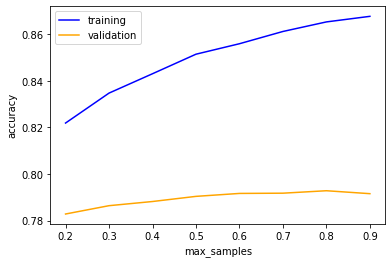

In [ ]:
plt.plot(samples, train_acc, color='blue', label='training')
plt.plot(samples, val_acc, color='orange', label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy')
plt.legend()
plt.show();

In [ ]:
depths = range(12, 20, 1)
train_acc = []
val_acc = []

for depth in depths:

  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(max_depth=depth, random_state=42,n_jobs=-1)
  )

  tree_model.fit(X_train, y_train)
  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

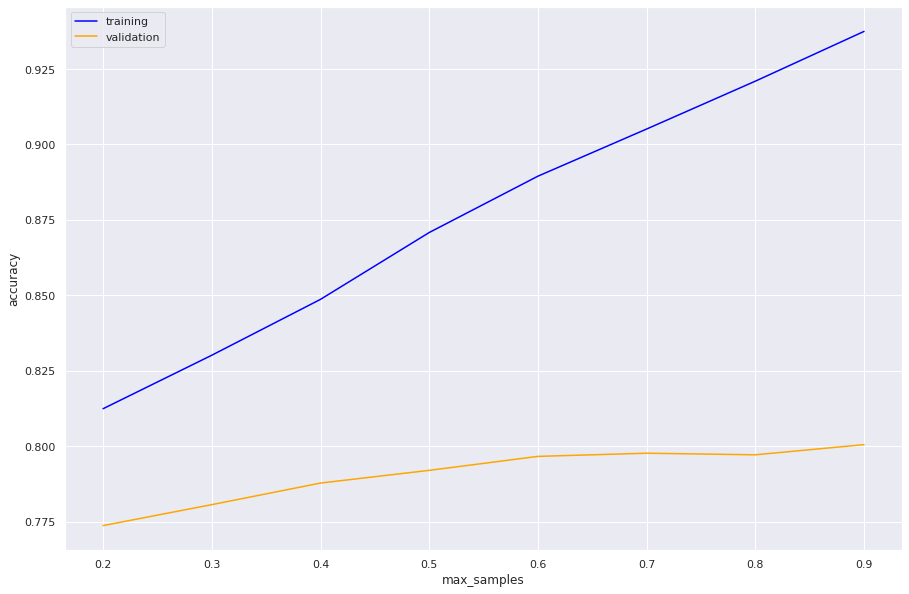

In [ ]:
plt.plot(samples, train_acc, color='blue', label='training')
plt.plot(samples, val_acc, color='orange', label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy')
plt.legend()
plt.show();

# VII. Communicate Results

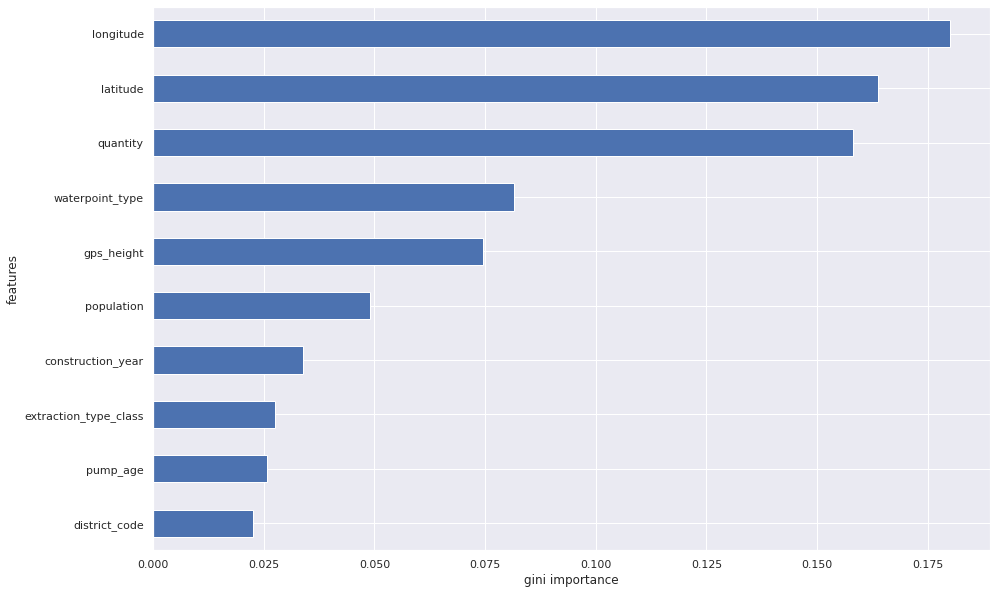

In [ ]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

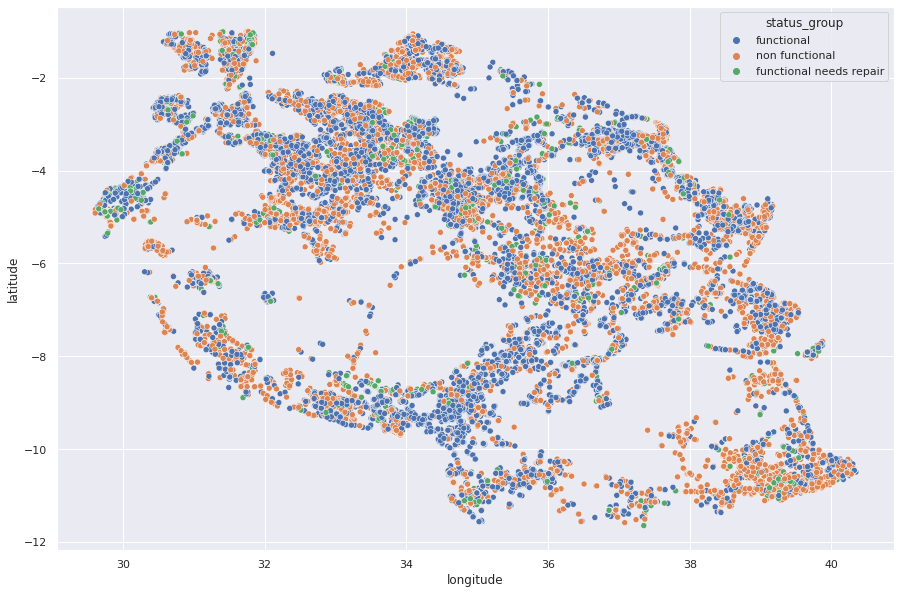

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x='longitude',y='latitude',data=df,hue='status_group');

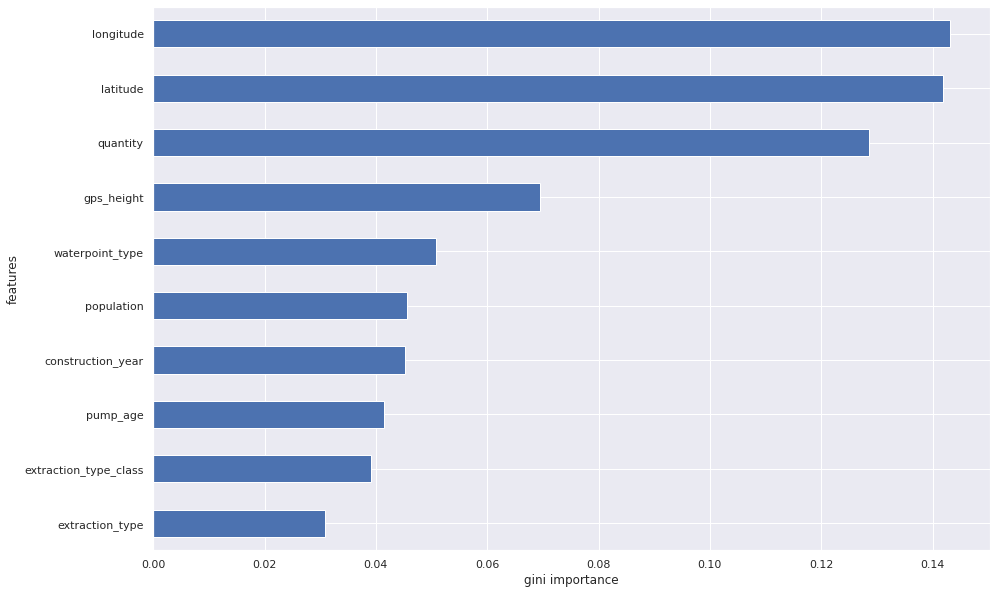

In [ ]:
features = model_rf.named_steps['ordinalencoder'].get_feature_names()
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance');

In [ ]:
model_rf.named_steps['randomforestclassifier'].estimators_[0]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1608637542, splitter='best')

In [ ]:
# plt.figure(figsize=(60,15))
# plot_tree(model_rf.named_steps['randomforestclassifier'].estimators_[0],
#                feature_names = X_train.columns, 
#                filled = True);